In [1]:
### Imports
import os
import numpy as np
import pandas as pd
import tifffile as tiff
from nd2reader import ND2Reader
from tqdm import tqdm
import btrack
from btrack.constants import BayesianUpdates
import json

In [2]:
# Variables
IMG_DIR = '/mnt/imaging.data/PertzLab/apoDetection/TIFFs'
APO_DIR = '/mnt/imaging.data/PertzLab/apoDetection/ApoptosisAnnotation'

MASK_DIR = '../data/apo_masks'
CSV_DIR = '../data/apo_match_csv'
DF_DIR = '../data/summary_dfs'
CROPS_DIR = '../data/apo_crops'
WINDOWS_DIR = '/home/nbahou/myimaging/apoDet/data/windows'


# Tracking
## Path to btrack config file
BT_CONFIG_FILE: str = "extras/cell_config.json"

## Tracking radius [px]
EPS_TRACK: int = 70

## Minimum track length [frames] (for filtering and passing on to ARCOS)
TRK_MIN_LEN: int = 60

In [8]:
# Load 
def load_image_stack(path):
    """
    Load an image stack from a file based on its extension.
    
    Uses tifffile for TIFF files and ND2Reader for ND2 files.
    """
    if path.endswith(('.tif', '.tiff')):
        # Load TIFF file using tifffile
        return tiff.imread(path)
    elif path.endswith('.nd2'):
        # Load ND2 file using ND2Reader and convert it to a numpy array
        with ND2Reader(path) as nd2:
            return np.array(nd2)
    else:
        raise ValueError(f"Unsupported file format for file: {path}")

def get_image_paths(directory):
    """
    Returns a list of absolute paths of all TIFF and ND2 files in a directory.
    """
    valid_extensions = ('.tif', '.tiff', '.nd2')
    paths = [
        os.path.abspath(os.path.join(directory, f))
        for f in os.listdir(directory)
        if f.endswith(valid_extensions)
    ]
    return sorted(paths)



def crop_window(img, center_x, center_y, window_size):
    # Check if number is even, add one if so
    if window_size%2 == 0:
        window_size += 1
        print(f'Window size even, adding 1.\n\tNew window size: {window_size}')
    half_window_size = window_size // 2
    x_from = max(center_x - half_window_size, 0)
    x_to = min(center_x + half_window_size + 1, img.shape[1])
    y_from = max(center_y - half_window_size, 0)
    y_to = min(center_y + half_window_size + 1, img.shape[0])
    window = img[y_from:y_to, x_from:x_to]

    return window

CLASS_DCT_PATH = './extras/class_dicts'
EXPERIMENT_INFO = '/mnt/imaging.data/PertzLab/apoDetection/List of the experiments.csv'

FRAME_INTERVAL = 5    # one image every 5 mins

experiments_list = pd.read_csv(EXPERIMENT_INFO, header=0)
#print(experiments_list)

# Create dirs if they do not exist yet
if not os.path.exists(CSV_DIR):
    os.makedirs(CSV_DIR)  
if not os.path.exists(MASK_DIR):
    os.makedirs(MASK_DIR)
if not os.path.exists(DF_DIR):
    os.makedirs(DF_DIR)
if not os.path.exists(CROPS_DIR):
    os.makedirs(CROPS_DIR)
if not os.path.exists(CLASS_DCT_PATH):
    os.makedirs(CLASS_DCT_PATH)
if not os.path.exists(WINDOWS_DIR):
    os.makedirs(WINDOWS_DIR)

#image_paths = []
image_paths = get_image_paths(os.path.join(IMG_DIR))

### TODO remove :2 here, was only for testing
# Extract filenames
image_paths = np.array(image_paths).flatten()[:3]
filenames = [os.path.splitext(os.path.basename(path))[0] for path in image_paths]

print(filenames)

MAX_TRACKING_DURATION = 20    # In minutes
FRAME_INTERVAL = 5    # minutes between images we want
num_timepoints = MAX_TRACKING_DURATION // FRAME_INTERVAL

# initalize a list to investigate track lengths after apoptosis
survival_times = []


# Main loop. Load mask, Track objects, Extract windows and create class df --> "obj_id" ->
for name in filenames:
    # Check if Acquisition_freq is multiple of target freq
    experiment_num = name.split('_')[0]
    matching_row = experiments_list[experiments_list['Experiment'] == experiment_num] 

    if matching_row.empty:
        print(f"Warning: Experiment {experiment_num} not found in the list. Skipping.")
        continue  # Skip this iteration
    
    acquisition_freq = matching_row['Acquisition_frequency(min)'].iloc[0]

    
    if FRAME_INTERVAL%acquisition_freq != 0:
        print(f"Skipping {name}: {FRAME_INTERVAL} is not a multiple of {acquisition_freq}.")
        continue
        
    step = FRAME_INTERVAL // acquisition_freq
    
    # Create directory for cropped windows
    if not os.path.exists(os.path.join(CROPS_DIR, name)):
            os.makedirs(os.path.join(CROPS_DIR, name))
    if not os.path.exists(os.path.join(WINDOWS_DIR, 'apo')):
            os.makedirs(os.path.join(WINDOWS_DIR, 'apo'))
    if not os.path.exists(os.path.join(CROPS_DIR, f'no_apo_{name}')):
            os.makedirs(os.path.join(CROPS_DIR, f'no_apo_{name}'))
    if not os.path.exists(os.path.join(WINDOWS_DIR, 'no_apo')):
            os.makedirs(os.path.join(WINDOWS_DIR, 'no_apo'))
    if not os.path.exists(os.path.join(CROPS_DIR, f'random_{name}')):
            os.makedirs(os.path.join(CROPS_DIR, f'random_{name}'))
    if not os.path.exists(os.path.join(WINDOWS_DIR, 'random')):
            os.makedirs(os.path.join(WINDOWS_DIR, 'random'))
        
    # Load mask file
    mask_path = os.path.join(MASK_DIR, f'{name}.npz')
    with np.load(mask_path) as data:
        labels = data['gt']

    # Load summary df 
    summary_df_path = os.path.join(DF_DIR, f'{name}_pd_df.csv')
    summary_df = pd.read_csv(summary_df_path)

    # Create btrack objects (with properties) from the segmentation data
    # By setting properties=('area',) the tracking algorithm takes into account the mask's area in addition to x/y.
    # By setting assign_class_ID=True adds the object ID that will be used later in merging tracking results with the dfProp table.
    btObj = btrack.utils.segmentation_to_objects(
            labels, properties=("area",), assign_class_ID=True
    )
    _, fovY, fovX = labels.shape
    
    with btrack.BayesianTracker() as tracker:
        # configure the tracker using a config JSON file
        tracker.configure(BT_CONFIG_FILE)
        tracker.update_method = BayesianUpdates.APPROXIMATE
        tracker.max_search_radius = EPS_TRACK
    
        # append the objects to be tracked
        tracker.append(btObj)
    
        # set the volume (Z axis volume limits default to [-1e5, 1e5] for 2D data)
        tracker.volume = ((0, fovX), (0, fovY))
    
        # track them (in interactive mode)
        tracker.track_interactive(step_size=100)
    
        # generate hypotheses and run the global optimizer
        tracker.optimize()
    
        # get the tracks as a python list
        btTracks = tracker.tracks


    dfBTracks = pd.concat(pd.DataFrame(t.to_dict(["ID", "t", "x", "y"])) for t in btTracks)

    dfBTracks.rename(
        columns={
            "ID": "track_id",
            "t": "t",
            "x": "x",
            "y": "y",
            "class_id": "obj_id"
        }, inplace = True
    )

    dfBTracks["obj_id"] = dfBTracks["obj_id"].astype("Int32")

    merged_df = summary_df.merge(dfBTracks.drop(columns=["x", "y", "area"]), on=["obj_id", "t"], how="left")
    merged_df_long = merged_df[merged_df.groupby("track_id")["track_id"].transform('size') >= TRK_MIN_LEN]

    ### Create class dict
    merged_df_long['apoptotic'] = 0

    # Load images to extract windows
    imgs = load_image_stack(os.path.join(IMG_DIR, f'{name}.tif'))

    # Load csv with manual apo annotations and new stardist centroids
    apo_file = os.path.join(CSV_DIR, f'{name}.csv')
    apo_annotations = pd.read_csv(apo_file, header=0)

    # Counter so we can sample same amount of random tracks as apoptotic
    num_random_tracks = 0 

    # Vars for window cropping
    num_frames = MAX_TRACKING_DURATION // acquisition_freq
    WINDOW_SIZE = 61
    target_size = WINDOW_SIZE if WINDOW_SIZE%2 != 0 else WINDOW_SIZE + 1

    print('Starting cropping for apo cells.')
    for i, row in apo_annotations.iterrows():
        current_object = row.loc['matching_object']
        current_t = row.loc['t']

        lookup_result = merged_df.loc[
            (merged_df['obj_id'] == current_object) & (merged_df['t'] == current_t),
            'track_id'
        ]
        
        if lookup_result.empty:
            print(f"Warning: No matching track_id for object {current_object} at time {current_t} in file {name}. Skipping.")
            continue
        
        current_track_id = lookup_result.squeeze()
        if not np.isscalar(current_track_id):
            current_track_id = current_track_id.iloc[0]

        
        
        
    
        single_cell_df = merged_df_long.loc[(merged_df_long['track_id'] == current_track_id) & (merged_df_long['t'] >= current_t)]

        
        # Count track length after manual apoptosis annotation (for histogram later)
        num_entries = single_cell_df.shape[0]
        survival_times.append(num_entries)

        single_cell_df = single_cell_df.loc[single_cell_df['t'] <= current_t + num_frames]
        
        
        merged_df_long.loc[single_cell_df.index, 'apoptotic'] = 1

        #single_cell_df = single_cell_df[::]
        
        windows = []
        ### TODO: put to variables
        for _, row in single_cell_df.iterrows():
            window = crop_window(imgs[row['t']], row['x'], row['y'], WINDOW_SIZE)
            if window.shape == (target_size, target_size):    ### This is a bit dangerous! can mess up time if we simply leave a window out
                windows.append(window)

        if len(windows) == MAX_TRACKING_DURATION + 1:
            windows = np.asarray(windows)
            tiff.imwrite(os.path.join(CROPS_DIR, name, f'trackID_{current_track_id}.tif'), windows[::step])
            tiff.imwrite(os.path.join(WINDOWS_DIR, 'apo', f'apo_{name}_{i}.tif'), windows[::step])
            num_random_tracks += 1
        else:
            print(f'\tAt least one of the images has the wrong size. Length = {len(windows)}. Pos = {row["x"]}, {row["y"]}')


    print('Starting cropping for non-apo cells.')
    # Get crops of healthy cells
    long_no_apo_df = merged_df_long[merged_df_long['apoptotic'] == 0]

    
    unique_track_ids = np.unique(long_no_apo_df['track_id'])

    for i, track_id in enumerate(unique_track_ids):
        single_cell_df = long_no_apo_df.loc[long_no_apo_df['track_id'] == track_id]
        start_t = min(single_cell_df['t'])
        # same length as for apoptotic cells
        single_cell_df = single_cell_df.loc[single_cell_df['t'] <= start_t + num_frames]
        windows = []
        for _, row in single_cell_df.iterrows():
            window = crop_window(imgs[row['t']], row['x'], row['y'], WINDOW_SIZE)
            if window.shape == (target_size, target_size):    ### This is a bit dangerous! can mess up time if we simply leave a window out
                windows.append(window)

        if len(windows) == MAX_TRACKING_DURATION + 1:
            windows = np.asarray(windows)
            tiff.imwrite(os.path.join(CROPS_DIR, f'no_apo_{name}', f'trackID_{track_id}.tif'), windows[::step])
            tiff.imwrite(os.path.join(WINDOWS_DIR, 'no_apo', f'no_apo_{name}_{i}.tif'), windows[::step])
        else:
            print(f'\tAt least one of the images has the wrong size. Length = {len(windows)}. Pos = {row["x"]}, {row["y"]}.')

    
    # Gather random crops 
    ### I think this could be problematic, oftentimes is full of cells so not really background or negative
    ### TODO Check that no apoptotic cell is in window
    print('Starting cropping for random locations.')

    # Assuming imgs is a list/array of your image frames,
    # and each image has dimensions: img_height x img_width
    img_height, img_width = imgs[0].shape
    
    # Create a directory for random crops if needed
    RANDOM_DIR = os.path.join(WINDOWS_DIR, 'random')
    os.makedirs(RANDOM_DIR, exist_ok=True)
    
    for track in range(num_random_tracks):
        # Randomly choose a start time such that the track fits in your image sequence
        start_t = np.random.randint(0, len(imgs) - num_frames)
        
        # Randomly generate valid (x, y) coordinates for the crop center
        random_x = np.random.randint(WINDOW_SIZE//2, img_width - WINDOW_SIZE//2)
        random_y = np.random.randint(WINDOW_SIZE//2, img_height - WINDOW_SIZE//2)
        
        windows = []
        # Extract a window for each frame in the track duration
        for t in range(start_t, start_t + num_frames + 1, step):  # using your step parameter
            window = crop_window(imgs[t], random_x, random_y, WINDOW_SIZE)
            if window.shape == (target_size, target_size):
                windows.append(window)
            else:
                print(f"Frame {t}: Invalid window shape, skipping.")
    
        if len(windows) == (MAX_TRACKING_DURATION/FRAME_INTERVAL) + 1:
            windows = np.asarray(windows)
            tiff.imwrite(os.path.join(CROPS_DIR, f'random_{name}', f'ID_{track}.tif'), windows[::step])
            tiff.imwrite(os.path.join(WINDOWS_DIR, 'random', f'random_{name}_{track}.tif'), windows[::step])
            
        else:
            print(f'\tAt least one of the images has the wrong size. Length = {len(windows)}')
                
    
    
    # Potentially better to work with merged df here
    class_dicts = []
    for t in merged_df_long['t'].unique():
        current_data = merged_df_long[merged_df_long['t'] == t]
        cls_dict = {}
        if not current_data.empty:  # Only fill the dictionary if there are rows
            for i, row in current_data.iterrows():
                cls_dict[f"{row['obj_id']}"] = int(row['apoptotic'])
        else:
            # If no data for the time point, append an empty dictionary
            cls_dict = {}
        class_dicts.append(cls_dict)

    with open(f'{CLASS_DCT_PATH}/{name}.json', 'w') as json_file:
        json.dump(class_dicts, json_file)
    
    
#os.path.join(DF_DIR, f'{filename}_pd_df.csv')
#tiff.imwrite('output.tif', arr)

['Exp01_Site01', 'Exp01_Site02', 'Exp01_Site03']


[INFO][2025/03/13 06:00:03 PM] Localizing objects from segmentation...
100%|███████████████████████████████████████████████████████████████████████████████| 1441/1441 [01:49<00:00, 13.17it/s]
[INFO][2025/03/13 06:01:53 PM] Objects are of type: <class 'dict'>
[INFO][2025/03/13 06:01:57 PM] ...Found 612856 objects in 1441 frames.
[INFO][2025/03/13 06:01:57 PM] Loaded btrack: /home/nbahou/miniforge3/envs/ERK_gpu/lib/python3.10/site-packages/btrack/libs/libtracker.so
[INFO][2025/03/13 06:01:57 PM] Starting BayesianTracker session
[INFO][2025/03/13 06:01:57 PM] Loading configuration file: extras/cell_config.json
[INFO][2025/03/13 06:01:57 PM] Objects are of type: <class 'list'>
[WARNING][2025/03/13 06:01:57 PM] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2025/03/13 06:01:57 PM] Starting tracking... 
[INFO][2025/03/13 06:01:57 PM] Update using: ['MOTION']
[INFO][2025/03/13 06:01:57 PM] Tracking objects in frames 0 to 99 (of 1441)...
[INFO][2025/03/13 06:01:58 PM]  - T

GLPK Integer Optimizer 5.0
29796 rows, 28305 columns, 42923 non-zeros
28305 integer variables, all of which are binary
Preprocessing...
14898 rows, 28305 columns, 42923 non-zeros
28305 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 14898
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
14898 rows, 28305 columns, 42923 non-zeros
*     0: obj =   8.451693242e+04 inf =   0.000e+00 (10678)
Perturbing LP to avoid stalling [511]...
*  8998: obj =   2.810959390e+04 inf =   2.000e-09 (1377) 5
Removing LP perturbation [10417]...
* 10417: obj =   2.708178225e+04 inf =   0.000e+00 (0) 4
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+ 10417: mip =     not found yet >=              -inf        (1; 0)
+ 10438: >>>>>   2.709167410e+04 >=   2.708690811e+04 < 0.1% (16; 0)
+ 10477: mip = 

[INFO][2025/03/13 06:02:14 PM] Completed optimization with 4929 tracks
[INFO][2025/03/13 06:02:15 PM] Ending BayesianTracker session
/tmp/ipykernel_2123648/2355635915.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_long['apoptotic'] = 0


Starting cropping for apo cells.
	At least one of the images has the wrong size. Length = 2. Pos = 968, 772
	At least one of the images has the wrong size. Length = 2. Pos = 996, 838
	At least one of the images has the wrong size. Length = 0. Pos = 452, 1000
	At least one of the images has the wrong size. Length = 0. Pos = 139, 0
	At least one of the images has the wrong size. Length = 20. Pos = 940, 528
Starting cropping for non-apo cells.
	At least one of the images has the wrong size. Length = 0. Pos = 1006, 666.
	At least one of the images has the wrong size. Length = 0. Pos = 10, 654.
	At least one of the images has the wrong size. Length = 0. Pos = 24, 734.
	At least one of the images has the wrong size. Length = 0. Pos = 1014, 728.
	At least one of the images has the wrong size. Length = 0. Pos = 18, 690.
	At least one of the images has the wrong size. Length = 0. Pos = 996, 560.
	At least one of the images has the wrong size. Length = 0. Pos = 4, 524.
	At least one of the image

[INFO][2025/03/13 06:02:43 PM] Localizing objects from segmentation...
100%|███████████████████████████████████████████████████████████████████████████████| 1441/1441 [01:42<00:00, 14.06it/s]
[INFO][2025/03/13 06:04:26 PM] Objects are of type: <class 'dict'>
[INFO][2025/03/13 06:04:30 PM] ...Found 566748 objects in 1441 frames.
[INFO][2025/03/13 06:04:30 PM] Loaded btrack: /home/nbahou/miniforge3/envs/ERK_gpu/lib/python3.10/site-packages/btrack/libs/libtracker.so
[INFO][2025/03/13 06:04:30 PM] Starting BayesianTracker session
[INFO][2025/03/13 06:04:30 PM] Loading configuration file: extras/cell_config.json
[INFO][2025/03/13 06:04:30 PM] Objects are of type: <class 'list'>
[WARNING][2025/03/13 06:04:30 PM] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2025/03/13 06:04:30 PM] Starting tracking... 
[INFO][2025/03/13 06:04:30 PM] Update using: ['MOTION']
[INFO][2025/03/13 06:04:31 PM] Tracking objects in frames 0 to 99 (of 1441)...
[INFO][2025/03/13 06:04:31 PM]  - T

GLPK Integer Optimizer 5.0
22416 rows, 20738 columns, 31011 non-zeros
20738 integer variables, all of which are binary
Preprocessing...
11208 rows, 20738 columns, 31011 non-zeros
20738 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 11208
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
11208 rows, 20738 columns, 31011 non-zeros
*     0: obj =   5.898442483e+04 inf =   0.000e+00 (7433)
Perturbing LP to avoid stalling [557]...
Removing LP perturbation [7305]...
*  7305: obj =   1.977132116e+04 inf =   1.332e-15 (0) 5
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  7305: mip =     not found yet >=              -inf        (1; 0)
+  7318: >>>>>   1.978664682e+04 >=   1.977801456e+04 < 0.1% (13; 0)
+  7362: mip =   1.978664682e+04 >=     tree is empty   0.0% (0; 45)
INTEGER 

[INFO][2025/03/13 06:04:42 PM] Completed optimization with 3870 tracks
[INFO][2025/03/13 06:04:43 PM] Ending BayesianTracker session
/tmp/ipykernel_2123648/2355635915.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_long['apoptotic'] = 0


Starting cropping for apo cells.
	At least one of the images has the wrong size. Length = 3. Pos = 26, 46
	At least one of the images has the wrong size. Length = 0. Pos = 554, 4
	At least one of the images has the wrong size. Length = 20. Pos = 626, 366
	At least one of the images has the wrong size. Length = 0. Pos = 1012, 312
	At least one of the images has the wrong size. Length = 20. Pos = 744, 168
	At least one of the images has the wrong size. Length = 10. Pos = 984, 50
	At least one of the images has the wrong size. Length = 0. Pos = 998, 78
	At least one of the images has the wrong size. Length = 11. Pos = 268, 386
	At least one of the images has the wrong size. Length = 12. Pos = 252, 250
	At least one of the images has the wrong size. Length = 16. Pos = 326, 580
	At least one of the images has the wrong size. Length = 20. Pos = 566, 506
	At least one of the images has the wrong size. Length = 20. Pos = 558, 646
	At least one of the images has the wrong size. Length = 20. Pos

[INFO][2025/03/13 06:05:09 PM] Localizing objects from segmentation...
100%|███████████████████████████████████████████████████████████████████████████████| 1441/1441 [01:32<00:00, 15.54it/s]
[INFO][2025/03/13 06:06:42 PM] Objects are of type: <class 'dict'>
[INFO][2025/03/13 06:06:44 PM] ...Found 465079 objects in 1441 frames.
[INFO][2025/03/13 06:06:44 PM] Loaded btrack: /home/nbahou/miniforge3/envs/ERK_gpu/lib/python3.10/site-packages/btrack/libs/libtracker.so
[INFO][2025/03/13 06:06:44 PM] Starting BayesianTracker session
[INFO][2025/03/13 06:06:44 PM] Loading configuration file: extras/cell_config.json
[INFO][2025/03/13 06:06:44 PM] Objects are of type: <class 'list'>
[WARNING][2025/03/13 06:06:45 PM] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2025/03/13 06:06:45 PM] Starting tracking... 
[INFO][2025/03/13 06:06:45 PM] Update using: ['MOTION']
[INFO][2025/03/13 06:06:45 PM] Tracking objects in frames 0 to 99 (of 1441)...
[INFO][2025/03/13 06:06:46 PM]  - T

GLPK Integer Optimizer 5.0
17628 rows, 16427 columns, 24612 non-zeros
16427 integer variables, all of which are binary
Preprocessing...
8814 rows, 16427 columns, 24612 non-zeros
16427 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 8814
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
8814 rows, 16427 columns, 24612 non-zeros
*     0: obj =   4.878999690e+04 inf =   0.000e+00 (5872)
Perturbing LP to avoid stalling [744]...
Removing LP perturbation [5805]...
*  5805: obj =   1.553888953e+04 inf =   0.000e+00 (0) 4
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  5805: mip =     not found yet >=              -inf        (1; 0)
+  5811: >>>>>   1.554828933e+04 >=   1.554520164e+04 < 0.1% (7; 0)
+  5812: mip =   1.554828933e+04 >=     tree is empty   0.0% (0; 13)
INTEGER OPTI

[INFO][2025/03/13 06:06:54 PM] Completed optimization with 2928 tracks
[INFO][2025/03/13 06:06:54 PM] Ending BayesianTracker session
/tmp/ipykernel_2123648/2355635915.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_long['apoptotic'] = 0


Starting cropping for apo cells.
	At least one of the images has the wrong size. Length = 9. Pos = 516, 248
	At least one of the images has the wrong size. Length = 0. Pos = 1016, 104
	At least one of the images has the wrong size. Length = 0. Pos = 14, 616
	At least one of the images has the wrong size. Length = 0. Pos = 1010, 580
	At least one of the images has the wrong size. Length = 0. Pos = 792, 872
	At least one of the images has the wrong size. Length = 11. Pos = 840, 456
Starting cropping for non-apo cells.
	At least one of the images has the wrong size. Length = 0. Pos = 20, 688.
	At least one of the images has the wrong size. Length = 0. Pos = 1006, 680.
	At least one of the images has the wrong size. Length = 0. Pos = 4, 640.
	At least one of the images has the wrong size. Length = 20. Pos = 606, 742.
	At least one of the images has the wrong size. Length = 0. Pos = 1018, 504.
	At least one of the images has the wrong size. Length = 18. Pos = 28, 596.
	At least one of the i

In [6]:
len(windows)

20

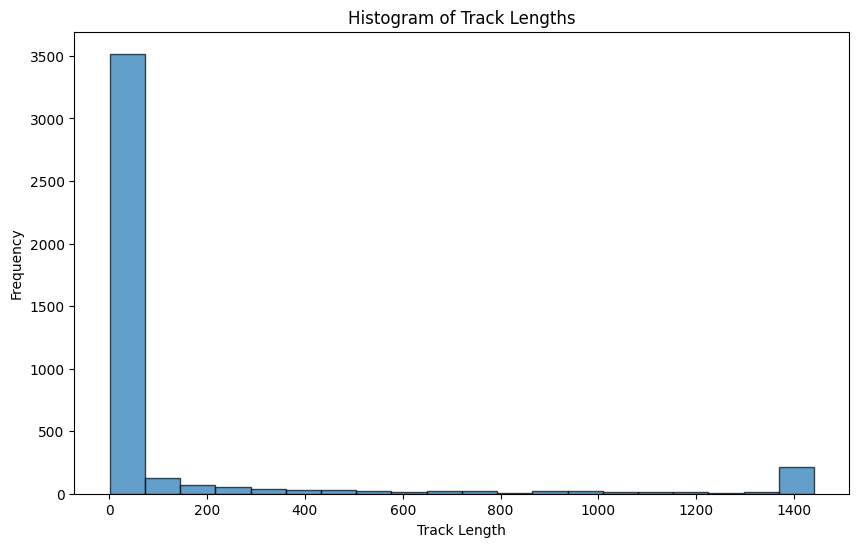

In [4]:
import matplotlib.pyplot as plt

# Count occurrences of each track_id to determine track lengths
track_lengths = merged_df["track_id"].value_counts()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(track_lengths, bins=20, edgecolor="black", alpha=0.7)

# Labels and title
plt.xlabel("Track Length")
plt.ylabel("Frequency")
plt.title("Histogram of Track Lengths")

# Show plot
plt.show()

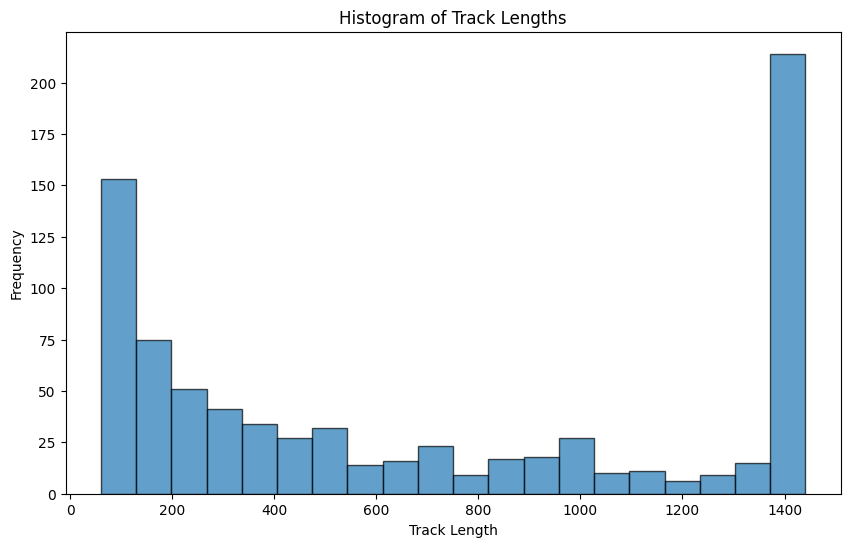

In [5]:
import matplotlib.pyplot as plt

# Count occurrences of each track_id to determine track lengths
track_lengths = merged_df_long["track_id"].value_counts()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(track_lengths, bins=20, edgecolor="black", alpha=0.7)

# Labels and title
plt.xlabel("Track Length")
plt.ylabel("Frequency")
plt.title("Histogram of Track Lengths")

# Show plot
plt.show()

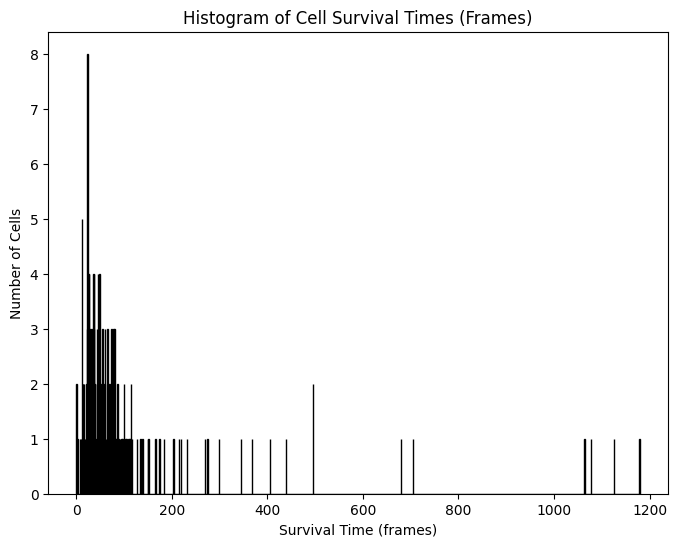

In [6]:
# Option 1: Histogram of survival times in frames
plt.figure(figsize=(8, 6))
plt.hist(survival_times, bins=range(min(survival_times), max(survival_times)+2), edgecolor='black')
plt.xlabel("Survival Time (frames)")
plt.ylabel("Number of Cells")
plt.title("Histogram of Cell Survival Times (Frames)")
plt.show()

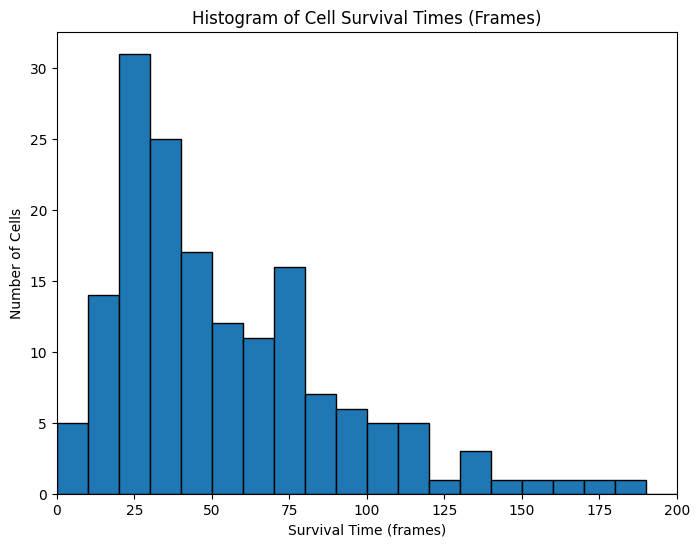

In [13]:
# Option 1: Histogram of survival times in frames
plt.figure(figsize=(8, 6))
plt.hist(survival_times, bins=20, range = (0, 200), edgecolor='black')
plt.xlim(0, 200)
plt.xlabel("Survival Time (frames)")
plt.ylabel("Number of Cells")
plt.title("Histogram of Cell Survival Times (Frames)")
plt.show()

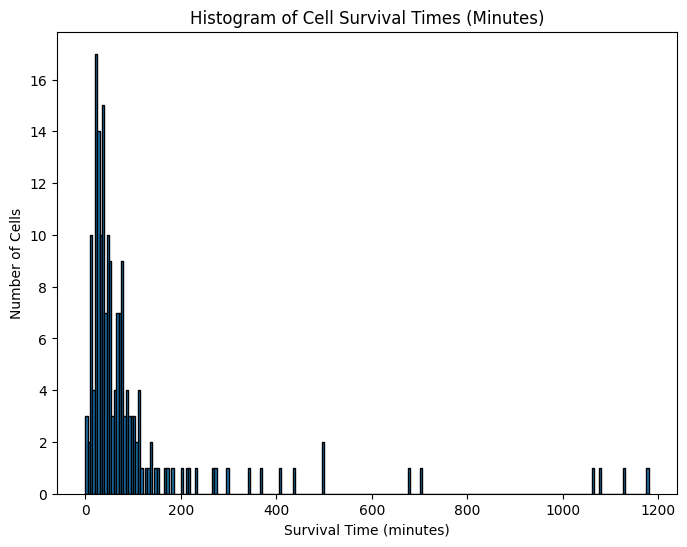

In [7]:
# Option 2: Convert survival times to minutes (if FRAME_INTERVAL is defined)
time_per_frame = 1    # One minute per frame

survival_times_minutes = [t * time_per_frame for t in survival_times]
plt.figure(figsize=(8, 6))
# Create bins with step size equal to FRAME_INTERVAL
bins = range(min(survival_times_minutes), max(survival_times_minutes) + FRAME_INTERVAL, FRAME_INTERVAL)
plt.hist(survival_times_minutes, bins=bins, edgecolor='black')
plt.xlabel("Survival Time (minutes)")
plt.ylabel("Number of Cells")
plt.title("Histogram of Cell Survival Times (Minutes)")
plt.show()